In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')

In [5]:
train_df.loc[train_df.Transported==True].shape[0]/train_df.shape[0] #没有样本不均衡的问题

0.5036236051995858

In [6]:
full_df = train_df.append(test_df, ignore_index=True)

In [7]:
full_df['HomePlanet'] = full_df['HomePlanet'].fillna('Earth')
full_df['CryoSleep'] = full_df['CryoSleep'].fillna(True)

In [8]:
full_df.loc[full_df.Cabin.notna(), 'Cabin_beck'] = \
         full_df.loc[full_df.Cabin.notna(), 'Cabin'].astype(str).map(lambda x: x.split('/')[0])
full_df.loc[full_df.Cabin.notna(), 'Cabin_side'] = \
         full_df.loc[full_df.Cabin.notna(), 'Cabin'].astype(str).map(lambda x: x.split('/')[2])                                                                                                                                                   

In [9]:
full_df['Cabin_beck'] = full_df['Cabin_beck'].fillna('F')
full_df['Cabin_side'] = full_df['Cabin_side'].fillna('P')

In [10]:
full_df['Destination'] = full_df['Destination'].fillna('TRAPPIST-1e')

In [11]:
full_df['Age'].fillna(full_df.Age.mean(), inplace=True)

In [12]:
full_df['VIP'].fillna(False, inplace=True)

In [13]:
full_df['RoomService'].fillna(full_df.RoomService.mode()[0], inplace=True)
full_df['FoodCourt'].fillna(full_df.FoodCourt.mode()[0], inplace=True)
full_df['ShoppingMall'].fillna(full_df.ShoppingMall.mode()[0], inplace=True)
full_df['Spa'].fillna(full_df.Spa.mode()[0], inplace=True)
full_df['VRDeck'].fillna(full_df.VRDeck.mode()[0], inplace=True)

In [16]:
from sklearn.preprocessing import LabelEncoder

In [17]:
full_data = full_df.copy()

In [18]:
columns = ["HomePlanet", "CryoSleep", "Destination", "VIP", "Cabin_beck", "Cabin_side"]
for column in columns:
    labelencoder = LabelEncoder()
    full_data[column] = labelencoder.fit_transform(full_data[column])

In [20]:
FEATURES = ["HomePlanet", "CryoSleep", "Destination", "Age", "VIP", "RoomService", \
            "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "Cabin_beck", "Cabin_side"]
TARGET = ["Transported"]

X_train = full_data[full_data.Transported.notna()][FEATURES]
y_train = full_data[full_data.Transported.notna()][TARGET].astype(int)

X_test = full_data[full_data.Transported.isna()][FEATURES]

In [22]:
y_train = y_train.values.ravel()

In [23]:
import xgboost as xgb

In [42]:
d_train = xgb.DMatrix(X_train, y_train)
params = {'objective': 'binary:logistic',
          'eta': 0.1}
ntree = 200
n_fold = 5
xgb_cv = xgb.cv(params, d_train, ntree, n_fold)
xgb_cv

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.652322,0.000599,0.654287,0.000724
1,0.618563,0.001129,0.622539,0.001497
2,0.590076,0.001192,0.595657,0.002435
3,0.565828,0.001297,0.573090,0.003238
4,0.544685,0.001783,0.553732,0.003643
...,...,...,...,...
195,0.287980,0.004244,0.417215,0.008492
196,0.287521,0.004223,0.417286,0.008541
197,0.287179,0.004013,0.417469,0.008499
198,0.286732,0.003788,0.417609,0.008550


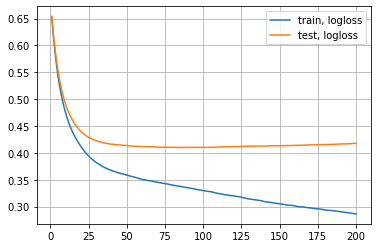

In [43]:
import matplotlib.pyplot as plt

plt.grid()
plt.plot(range(1, 201), xgb_cv["train-logloss-mean"], label="train, logloss")
plt.plot(range(1, 201), xgb_cv["test-logloss-mean"], label="test, logloss")
plt.legend(loc='best')
plt.show()

In [38]:
params = {'objective': 'binary:logistic',
          'eta': 0.1,
          'eval_metric': "error"}
ntree = 200
n_fold = 5
xgb_cv = xgb.cv(params, d_train, ntree, n_fold)
xgb_cv

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.208328,0.005641,0.224547,0.009692
1,0.203842,0.008403,0.219946,0.009260
2,0.199528,0.005537,0.217185,0.013275
3,0.195473,0.002843,0.213618,0.013022
4,0.193431,0.002257,0.212239,0.011568
...,...,...,...,...
195,0.126567,0.003831,0.199010,0.004453
196,0.126280,0.003810,0.199010,0.004682
197,0.125992,0.003677,0.198895,0.004618
198,0.125676,0.003406,0.199010,0.004625


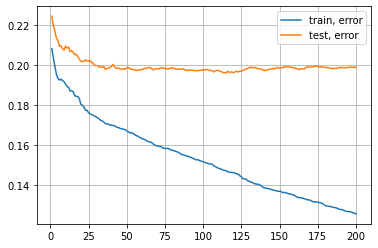

In [41]:
plt.grid()
plt.plot(range(1, 201), xgb_cv["train-error-mean"], label="train, error")
plt.plot(range(1, 201), xgb_cv["test-error-mean"], label="test, error")
plt.legend(loc='best')
plt.show()

In [44]:
params = {'objective': 'binary:logistic',
          'eta': 0.1,
          'eval_metric': "auc"}
ntree = 100
n_fold = 5
xgb_cv = xgb.cv(params, d_train, ntree, n_fold)
xgb_cv

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.871893,0.001751,0.853328,0.010097
1,0.878794,0.004645,0.859349,0.010660
2,0.883795,0.004027,0.864147,0.012201
3,0.888485,0.001680,0.868765,0.011335
4,0.891199,0.000987,0.869801,0.009794
...,...,...,...,...
195,0.954505,0.001758,0.887105,0.004610
196,0.954697,0.001751,0.887089,0.004584
197,0.954833,0.001671,0.887011,0.004594
198,0.955004,0.001592,0.886960,0.004590


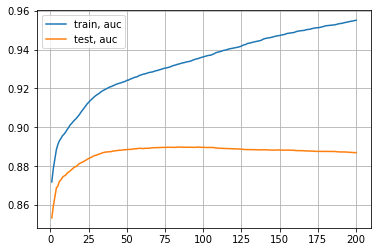

In [45]:
plt.grid()
plt.plot(range(1, 201), xgb_cv["train-auc-mean"], label="train, auc")
plt.plot(range(1, 201), xgb_cv["test-auc-mean"], label="test, auc")
plt.legend(loc='best')
plt.show()

In [84]:
param1 = {'objective':'binary:logistic'
          ,"subsample":1
          ,"max_depth":3
          ,"eta":0.2
          ,"gamma":2
          ,"lambda":1
          ,"alpha":0
          ,"colsample_bytree":1
          ,"colsample_bylevel":1
          ,"colsample_bynode":1
          ,"eval_metric":'auc'
          }
ntree = 100
n_fold=5
xgb_cv_01 = xgb.cv(param1, d_train, ntree, n_fold)
xgb_cv_01

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.803028,0.004847,0.795752,0.008557
1,0.832749,0.002732,0.825763,0.005568
2,0.843138,0.004734,0.834290,0.007124
3,0.849698,0.002388,0.840013,0.008135
4,0.853607,0.003270,0.845582,0.007392
...,...,...,...,...
95,0.904034,0.001930,0.885750,0.006842
96,0.904034,0.001930,0.885750,0.006842
97,0.904034,0.001930,0.885750,0.006842
98,0.904034,0.001930,0.885750,0.006842


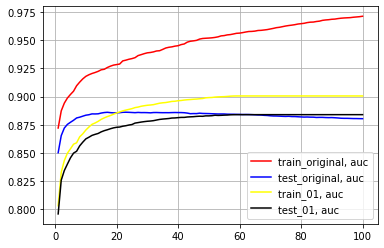

In [81]:
plt.grid()
plt.plot(range(1, 101), xgb_cv["train-auc-mean"], color="red", label="train_original, auc")
plt.plot(range(1, 101), xgb_cv["test-auc-mean"], color="blue", label="test_original, auc")
plt.plot(range(1, 101), xgb_cv_01["train-auc-mean"], color="yellow", label="train_01, auc")
plt.plot(range(1, 101), xgb_cv_01["test-auc-mean"], color="black", label="test_01, auc")
plt.legend(loc='best')
plt.show()

In [85]:
d_test = xgb.DMatrix(X_test)
xgb_model = xgb.train(param1, d_train, ntree)
y_pred = xgb_model.predict(d_test)

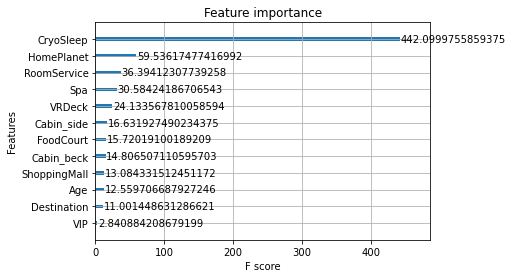

In [90]:
xgb.plot_importance(xgb_model, importance_type="gain")
plt.show()

In [ ]:
y_pred1 = np.where(y_pred >= 0.5, 1, 0)
y_pred1 = y_pred1.astype(bool)

In [95]:
output1 = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Transported': y_pred1})
output1.to_csv('output/xgb_submission_ver01_thre0.5.csv', index=False)

In [96]:
d_test = xgb.DMatrix(X_test)
xgb_model = xgb.train(param1, d_train, ntree)
y_pred = xgb_model.predict(d_test)

In [97]:
y_pred1 = np.where(y_pred >= 0.5, 1, 0)
y_pred1 = y_pred1.astype(bool)
output1 = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Transported': y_pred1})
output1.to_csv('output/xgb_submission_ver01_noparams.csv', index=False)